# Mixtures of PPCA's
In this chapter, we introduce mixtures of PPCA models.

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from utils import loadStan
sns.set()

In [3]:
moppcas_model = loadStan('moppcas')
ppca_model = loadStan('ppca')

Model loaded succesfully from cache.
Model loaded succesfully from cache.


In [26]:
N=1000
M=2
D=3
K=5
mu = np.random.uniform(-50,50,size=(K,D))
sigma = np.random.uniform(0,3,size=(K))
while True:      # make sure to not have a negligible cluster
    theta = np.random.dirichlet(np.ones(K))
    if np.all(theta>(1.0/(2*K))):
        break

z = []
W = []
for k in range(K):
    W.append(np.random.normal(0,1.5,size=(D,M)))
    z.append(np.random.normal(0,1, size=(M,N)))
    
x = np.zeros((N,D))
ind = []
for n in range(N):
    opt = np.random.choice(list(range(K)),p=theta)
    x[n,:] = np.random.normal(np.matmul(W[opt],z[opt][:,n])+mu[opt], sigma[opt])
    ind.append(opt)

print('theta: ', theta)
print()
for k in range(K):
    print('W_'+str(k)+':\n',W[k])
    print('mu_'+str(k)+': ',mu[k,:])
    print('sigma_'+str(k)+': ',sigma[k])
    print()

theta:  [0.10494463 0.1404876  0.32894216 0.26336142 0.16226419]

W_0:
 [[ 0.68301625 -0.15020598]
 [-1.45095704  0.63191271]
 [-1.05629514 -0.5418867 ]]
mu_0:  [-33.23209242 -22.0681476  -39.59757501]
sigma_0:  2.255175881550419

W_1:
 [[-4.05498442  1.00046619]
 [-1.15675571 -1.0288976 ]
 [ 0.1807593   0.40394475]]
mu_1:  [-14.32306889  42.23450783 -44.77932185]
sigma_1:  0.577678868449327

W_2:
 [[ 0.76558996  1.01950081]
 [-3.84959254  1.37683463]
 [ 3.8651463  -0.56075578]]
mu_2:  [-30.19829401 -14.80868253  42.76864717]
sigma_2:  1.2786116147060063

W_3:
 [[-1.15039493 -2.618534  ]
 [ 1.84890726  1.68567672]
 [ 0.50775886  2.23261401]]
mu_3:  [46.31707489 -1.84661606 40.17741805]
sigma_3:  1.4737805517207878

W_4:
 [[ 1.22216144  0.57883268]
 [-1.90720402  2.4946367 ]
 [-1.1820188  -0.39187322]]
mu_4:  [  0.97486201  17.41782575 -33.73159941]
sigma_4:  0.7209096246838151



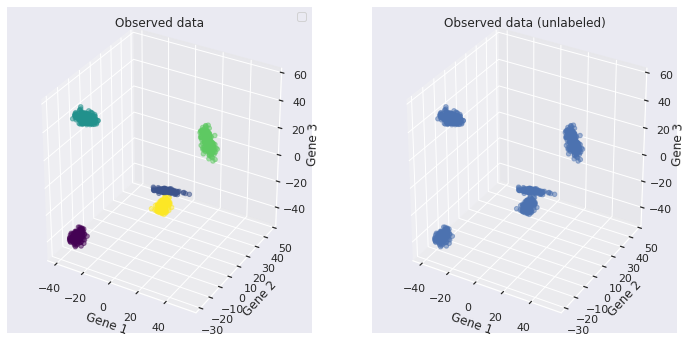

In [27]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis', alpha=0.5)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], cmap='viridis', alpha=0.5)
ax.set_title('Observed data (unlabeled)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

Since the optimization is highly dependend on the initial values, we initialize $\mu$ with a simple $k$-means clustering algorithm. It is also possible to initialize the inidivual factor laoding matrices $W_k$ as the factor loading matrix found when fitting a PPCA on the whole dataset.

In [28]:
ppca_dat = {'N':N, 'M':M, 'D':D, 'x':x}
fit_init = ppca_model.sampling(data=ppca_dat, chains=1, iter=100)
W_init = np.mean(fit_init.extract()['W'], axis=0)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [29]:
kmeans_init = KMeans(K).fit(x)

gmm_dat = {'N': N, 'M': M, 'K': K, 'D':D, 'y':x}
fit = moppcas_model.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':kmeans_init.cluster_centers_}])
fit_ext = fit.extract()
best_ind = np.where(fit_ext['lp__']==max(fit_ext['lp__']))[0][0]
fit_W = moppcas_model.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':kmeans_init.cluster_centers_, 'W':[W_init for k in range(K)]}])
fit_ext_W = fit_W.extract()
best_ind_W = np.where(fit_ext_W['lp__']==max(fit_ext_W['lp__']))[0][0]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


RuntimeError: Initialization failed.

In [ ]:
theta_sim = np.mean(fit_ext['theta'],axis=0)
mu_sim = np.mean(fit_ext['mu'],axis=0)
sigmas_sim = np.mean(fit_ext['sigma'],axis=0)
z_sim = fit_ext['z'][best_ind]
W_sim = np.mean(fit_ext['W'],axis=0)
clusters = np.mean(fit_ext['clusters'],axis=0)

theta_sim_W = np.mean(fit_ext_W['theta'],axis=0)
mu_sim_W = np.mean(fit_ext_W['mu'],axis=0)
sigmas_sim_W = np.mean(fit_ext_W['sigma'],axis=0)
z_sim_W = fit_ext_W['z'][best_ind_W]
W_sim_W = np.mean(fit_ext_W['W'],axis=0)
clusters_W = np.mean(fit_ext_W['clusters'],axis=0)

order = True         # this tries to set the simulated clusters in the same order as the original; good for testing, but costly for real use
if order:
    mu_diffs = np.ones((K,K))
    mu_diffs_W = np.ones((K,K))
    for i in range(K):
        for j in range(K):
            mu_diffs[i,j] = sum([(mu[i][d]-mu_sim[j][d])**2 for d in range(D)])
            mu_diffs_W[i,j] = sum([(mu[i][d]-mu_sim_W[j][d])**2 for d in range(D)])

    best_score = 10000
    best_score_W = 10000
    for perm in list(itertools.permutations(list(range(K)))):
        score = 0
        score_W = 0
        for i,j in enumerate(perm):
            score+=mu_diffs[i,j]
            score_W+=mu_diffs_W[i,j]
        if score<best_score:
            best_order = perm
            best_score = score
        if score_W<best_score_W:
            best_order_W = perm
            best_score_W = score_W
    
    theta_sim = np.array([theta_sim[i] for i in best_order])
    mu_sim = np.array([mu_sim[i] for i in best_order])
    sigmas_sim = np.array([sigmas_sim[i] for i in best_order])
    z_sim = [z_sim[i] for i in best_order]
    W_sim = np.array([W_sim[i] for i in best_order])
    clusters = np.array([clusters[:,i] for i in best_order]).T

    theta_sim_W = np.array([theta_sim_W[i] for i in best_order])
    mu_sim_W = np.array([mu_sim_W[i] for i in best_order])
    sigmas_sim_W = np.array([sigmas_sim_W[i] for i in best_order])
    z_sim_W = [z_sim_W[i] for i in best_order]
    W_sim_W = np.array([W_sim_W[i] for i in best_order])
    clusters_W = np.array([clusters_W[:,i] for i in best_order]).T

print('Real theta: ',theta)
print('Sample theta: ',[sum(np.array(ind)==k)/N for k in range(K)])
print('Simulated theta: ',theta_sim)
print('Simulated theta (initialized W): ',theta_sim_W)
print()
print('actual mu:\n',mu)
print('Simulated mu:\n',mu_sim)
print('Simulated mu (initialized W):\n',mu_sim_W)
print()
print('actual sigmas: ',sigma)
print('Simulated sigmas: ',sigmas_sim)
print('Simulated sigmas (initialized W): ',sigmas_sim_W)
print()
for k in range(K):
    print('Actual WW^T_'+str(k+1)+': ')
    print(np.matmul(W[k],W[k].T))
    print('Simulated WW^T_'+str(k+1)+': ')
    print(np.matmul(W_sim[k],W_sim[k].T))
    print('Simulated WW^T_'+str(k+1)+' (initialized W): ')
    print(np.matmul(W_sim_W[k],W_sim_W[k].T))
    print()

clusters_norm = (np.exp(clusters).T/sum(np.exp(clusters).T)).T
z_cats = np.argmax(clusters_norm, axis=1)
clusters_norm_W = (np.exp(clusters_W).T/sum(np.exp(clusters_W).T)).T
z_cats_W = np.argmax(clusters_norm_W, axis=1)

In [ ]:
x_rec = np.zeros((N,D))
ind_rec = []
x_rec_W = np.zeros((N,D))
ind_rec_W = []
for n in range(N):
    opt = np.random.choice(list(range(K)),p=theta_sim)
    x_rec[n,:] = np.random.normal(np.matmul(W_sim[opt],z_sim[opt][:,n])+mu_sim[opt], sigmas_sim[opt])
    ind_rec.append(opt)
    opt = np.random.choice(list(range(K)),p=theta_sim_W)
    x_rec_W[n,:] = np.random.normal(np.matmul(W_sim_W[opt],z_sim_W[opt][:,n])+mu_sim_W[opt], sigmas_sim_W[opt])
    ind_rec_W.append(opt)

In [ ]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(2,3,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=ind, cmap='viridis', alpha=0.05)
ax.scatter(mu[:,0],mu[:,1],mu[:,2], c='red', s=50, zorder=2, alpha=1)
ax.set_title('Observed data (Actual clusters)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(2,3,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=z_cats, cmap='viridis', alpha=0.05,zorder=1)
ax.scatter(mu_sim[:,0],mu_sim[:,1],mu_sim[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Guessed Clusters)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(2,3,3, projection='3d')
ax.scatter(x_rec[:,0],x_rec[:,1],x_rec[:,2],c=ind_rec, cmap='viridis', alpha=0.05, zorder=1)
ax.scatter(mu_sim[:,0],mu_sim[:,1],mu_sim[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Recreated data)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(2,3,4, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=ind, cmap='viridis', alpha=0.05)
ax.scatter(mu[:,0],mu[:,1],mu[:,2], c='red', s=50, zorder=2, alpha=1)
ax.set_title('Observed data (Actual clusters)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(2,3,5, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=z_cats_W, cmap='viridis', alpha=0.05,zorder=1)
ax.scatter(mu_sim_W[:,0],mu_sim_W[:,1],mu_sim_W[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Guessed Clusters\nwith initialized W)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(2,3,6, projection='3d')
ax.scatter(x_rec_W[:,0],x_rec_W[:,1],x_rec_W[:,2],c=ind_rec, cmap='viridis', alpha=0.05, zorder=1)
ax.scatter(mu_sim_W[:,0],mu_sim_W[:,1],mu_sim_W[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Recreated data\nwith initialized W)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

The red dots in the above plot illustrate the real (left figure) and estimated (centre and right figure) values of $\mu$. (They are not always perfectly visible though, sorry for the inconvenience.)
Clearly, initializing $W$ did not help our algorithm. We'll leave it out in the future.

In [ ]:
for k in range(K):
    print('Actual mean of latent cluster '+str(k), np.mean(z[k],axis=1))
    print('Actual std. dev of latent cluster '+str(k), np.std(z[k],axis=1))
    print('Estimated mean of latent cluster '+str(k), np.mean(z_sim[k],axis=1))
    print('Estimated std. dev of latent cluster '+str(k), np.std(z_sim[k],axis=1))
    print()

In [ ]:
cols = [[1,0,0], [0,0.6,0],[0,0,1],[0.5,0,0.5],[0.5,0.5,0]]

sns.set()
vis_threshold = 0.001

fig = plt.figure(figsize=(25,12))
for k in range(K):
    ax = fig.add_subplot(2,K,k+1)
    ax.scatter(z[k][0,np.array(ind)==k],z[k][1,np.array(ind)==k], c=np.outer(np.ones(len(z[k][0,np.array(ind)==k])),cols[k]))
    ax.set_title('Actual latent data: cluster '+str(k+1))
    
for k in range(K):
    ax = fig.add_subplot(2,K,K+k+1)
    plotz = z_sim[k][:,clusters_norm[:,k]>vis_threshold]
    rgba_colors = np.zeros((sum(clusters_norm[:,k]>vis_threshold),4))
    for k_i in range(K):
        rgba_colors[np.array(ind)[clusters_norm[:,k]>vis_threshold]==k_i,:3] = cols[k_i]
    rgba_colors[:, 3] = clusters_norm[:,k][clusters_norm[:,k]>vis_threshold]
    ax.scatter(plotz[0,:],plotz[1,:], c=rgba_colors)
    ax.set_title('Simulated latent data: cluster '+str(k+1))
    
plt.show()

for k in range(K):
    weights = clusters_norm[:,k]
    zbark = z_sim[k]
    print('Cluster '+str(k)+':')
    print('Real sample mean: ', np.mean(z[k][:,np.array(ind)==k],axis=1))
    weigh_mu_sim = np.sum(zbark*weights,axis=1)/sum(weights)
    print('Simulated (weighted) mean: ', weigh_mu_sim)
    print('Real sample std. dev.: ',np.std(z[k][:,np.array(ind)==k],axis=1))
#     M_v = sum(clusters[:,k]>0.0)
    weighted_cov = np.sqrt(np.cov(zbark, aweights=weights))
    print('Simulated (weighted) std. dev.: ', weighted_cov[0,0],weighted_cov[1,1])
#     print('Simulated (weighted) std. dev.: ', np.sqrt(np.sum(np.square(zbark.T-weigh_mu_sim).T*weights,axis=1)/(sum(weights)*((M_v-1)/M_v))))
    print()

And we end up with all all latent data in separate clusters!